In [1]:
import pandas as pd

# 读取数据
df = pd.read_csv("/Users/angelatao/Desktop/fine_gained_sentiment_analysis/data/Labeled_Reddit_Data.csv")

# 定义所有可能的情感类别
all_emotions = ["confidence", "satisfaction", "hope", "trust_medical", "anxiety", "anger"]

# 初始化所有情感列为 0
for emotion in all_emotions:
    df[emotion] = df['emotions'].apply(lambda x: 1 if emotion in x else 0)

# 现在 df 里每个情感都是独立的二进制列
print(df.head())


        id                                           selftext  \
0  1gzxiij  Background: I am an Internal Medicine physicia...   
1  1gzvuba  I have an issue and it plague's my brain on a ...   
2  1gzv22e  Medicare payments are scheduled to decrease in...   
3  1gzubf1  [The Perverse Consequences of Tuition-Free Med...   
4  1gzhrmq  I read an article on bloomberg that seems pert...   

                                            emotions  confidence  \
0         confidence,satisfaction,hope,trust_medical           1   
1                                      anxiety,anger           0   
2  confidence,satisfaction,anxiety,hope,trust_med...           1   
3                        anxiety,anger,trust_medical           0   
4                        anxiety,anger,trust_medical           0   

   satisfaction  hope  trust_medical  anxiety  anger  
0             1     1              1        0      0  
1             0     0              0        1      1  
2             1     1              

Using device: mps


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Training: 100%|██████████| 920/920 [19:04<00:00,  1.24s/it, loss=0.0574]


Training Loss: 0.2341


Validation: 100%|██████████| 103/103 [00:23<00:00,  4.35it/s]


Validation Loss: 0.5564 | F1 Score: 0.8879 | AUC Score: 0.9791

Epoch 2/3


Training: 100%|██████████| 920/920 [17:03<00:00,  1.11s/it, loss=0.0386]


Training Loss: 0.1260


Validation: 100%|██████████| 103/103 [00:21<00:00,  4.73it/s]


Validation Loss: 0.5504 | F1 Score: 0.8801 | AUC Score: 0.9807

Epoch 3/3


Training: 100%|██████████| 920/920 [14:52<00:00,  1.03it/s, loss=0.0471] 


Training Loss: 0.0886


Validation: 100%|██████████| 103/103 [00:21<00:00,  4.78it/s]


Validation Loss: 0.5465 | F1 Score: 0.8750 | AUC Score: 0.9747


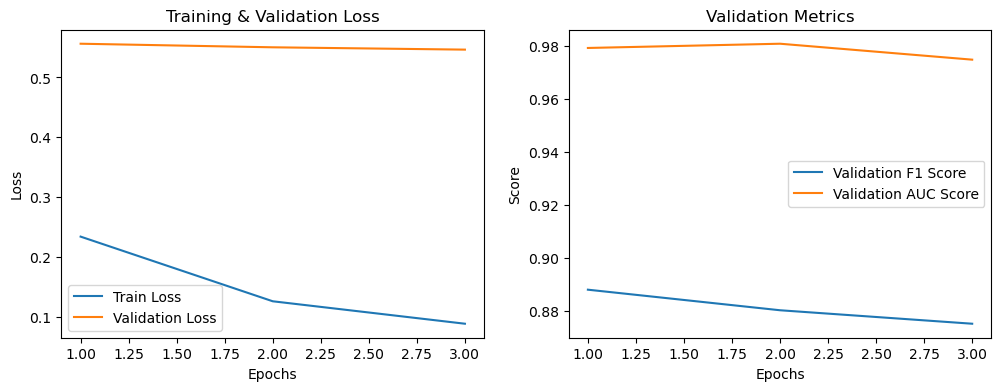

In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from tqdm import tqdm

# 检测 MPS（Apple GPU）或 CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 读取数据
df = pd.read_csv("/Users/angelatao/Desktop/fine_gained_sentiment_analysis/data/Labeled_Reddit_Data.csv")

# 定义所有可能的情感类别
all_emotions = ["confidence", "satisfaction", "hope", "trust_medical", "anxiety", "anger"]

# 将情感转换为二进制向量
for emotion in all_emotions:
    df[emotion] = df['emotions'].apply(lambda x: 1 if emotion in x else 0)

# 划分训练和验证集
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["selftext"].tolist(), df[all_emotions].values.tolist(), test_size=0.1, random_state=42
)

# 载入 tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# 自定义 Dataset
class RedditDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": labels
        }

# 创建 Dataset 和 DataLoader
train_dataset = RedditDataset(train_texts, train_labels)
val_dataset = RedditDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# 加载 RoBERTa 模型
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(all_emotions))
model.to(device)

# 选择优化器和损失函数
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = BCEWithLogitsLoss()

# 训练参数
EPOCHS = 3
train_losses = []
val_losses = []
val_f1_scores = []
val_auc_scores = []

# 训练过程
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # 训练模式
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # 验证模式
    model.eval()
    val_loss = 0
    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits.sigmoid().cpu().numpy()  # 转换成概率
            loss = loss_fn(torch.tensor(logits), torch.tensor(labels))

            val_loss += loss.item()
            true_labels.extend(labels)
            predictions.extend(logits)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    f1 = f1_score(true_labels, np.array(predictions) > 0.5, average="macro")
    auc = roc_auc_score(true_labels, predictions, average="macro")

    val_f1_scores.append(f1)
    val_auc_scores.append(auc)

    print(f"Validation Loss: {avg_val_loss:.4f} | F1 Score: {f1:.4f} | AUC Score: {auc:.4f}")

# 保存模型
model.save_pretrained("roberta_sentiment_model")
tokenizer.save_pretrained("roberta_sentiment_model")

# 训练可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), val_f1_scores, label="Validation F1 Score")
plt.plot(range(1, EPOCHS + 1), val_auc_scores, label="Validation AUC Score")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.title("Validation Metrics")

plt.show()
